<h2 align="center">BERT_Email_Classification</h2>

In this tutorial, we will build a spam detection model. The spam detection model will classify emails as spam or not spam. This will be used to filter unwanted and unsolicited emails. We will build this model using BERT and Tensorflow.

BERT will be used to generate sentence encoding for all emails. Finally, we will use Tensorflow to build the neural networks. Tensorflow will create the input and output layers of our machine learning model.

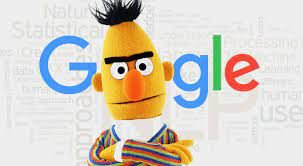

#Importing important packages

tensorflow_text: It will allow us to work with text. In this tutorial, we are solving a text-classification problem

In [2]:
#pip install tensorflow-text==2.6.0
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.0 MB/s eta 0:00:00


tensorflow: It is the machine learning package used to build the neural network. It will create the input and output layers of our machine learning model.

tensorflow_hub: It contains a pre-trained machine model used to build our text classification. Our pre-trained model is BERT. We will re-use the BERT model and fine-tune it to meet our needs.

tensorflow_text: It will allow us to work with text. In this tutorial, we are solving a text-classification problem.

pandas: We will use Pandas to load our dataset. We also use Pandas for data manipulation and analysis. It gives us a clear overview of how our dataset is structured.

In [3]:
#import above mentioned libraries
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Import the dataset from here:

In [4]:
#read the data set
df = pd.read_csv("/content/spam.csv")
#print top 5 data
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


our dataset has two categories: ham and spam. ham represents the emails that are not spam, this are emails from a trusted source. spam represents emails from an unknown source.

The dataset also has the Message column. This column represents the email messages. Let’s see the individual value count for the spam and ham emails.

In [8]:
#checking the count of category
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

we have 4825 ham emails and 747 spam emails. The ham email has a significantly higher number.

The ratio of the two categories is shown below:

In [9]:
#divide ham with spam to check the ratio
747/4825

0.15481865284974095

This result implies that about 15% are spam emails and 85% of ham emails. This indicates a class imbalance. We need to balance the two classes to reduce bias during model training.

**15% spam emails, 85% ham emails: This indicates class imbalance**

#Balancing dataset
We have various techniques that are used to balance the dataset. In this tutorial, we will use the most simple approach. We will reduce 4825 of the majority class to 747. This will make the two classes balanced.

we balance the two classes, let’s create data frames for the individual classes.

In [10]:
#checking the shape of spam
df_spam = df[df["Category"] == "spam"]
#print shape
df_spam.shape

(747, 2)

In [11]:
#checking the shape of ham
df_ham = df[df["Category"] == "ham"]
#print shape
df_ham.shape

(4825, 2)

Now that we have created the two data frames, we will reduce the number of the ham class to be equal to the spam class.


In [12]:
#take shape [0]
#df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
#print the shape
df_ham_downsampled.shape

(747, 2)

We will save the new class into a df_ham_downsampled variable. We need to concatenate the two balanced classes into a single data frame.

In [13]:
#concat the df_ham_downsampled, df_spam
df_balanced = pd.concat([df_ham_downsampled,df_spam])
#print the shape
df_balanced.shape

(1494, 2)

The pd.concat method will concatenate df_ham_downsampled and df_spam into a single data frame. It will save the dataset into a variable df_balanced.

In [14]:
#checking the balanced count of category
df_balanced["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

#Adding labels
We need to label our dataset into 1 and 0. 1 will represent the data samples that belong to the spam class. 0 will represent the data samples that belong to the ham class.<br>
We use lambda to write our logic. The apply method will run the written logic. This will enable us to label our dataset.

In [16]:
#apply the condition with lambda
#if spam print l
#else print 0
#df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced["spam"] = df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)
#print the top partial view
df_balanced.sample(5)

,Category,Message,spam
3640,ham,Wat's da model num of ur phone?,0
3598,spam,Congratulations YOU'VE Won. You're a Winner in...,1
2430,spam,Guess who am I?This is the first time I create...,1
5229,ham,It means u could not keep ur words.,0
1502,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,1


we can see that the dataset is labeled into two. Some of the data samples are labeled 1 while others are labeled 0. We now need to split our labeled dataset.

#Split it into training and test dataset

We split our dataset into two sets, the first set will be used for training and the second set will be used for testing.

In [17]:
#import train_test_split from sklearn
from sklearn.model_selection import train_test_split
#use train_test_split in df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam']
X_train,X_test,y_train,y_test = train_test_split(df_balanced["Message"],df_balanced["spam"],stratify = df_balanced["spam"])

In [19]:
#print the head of X_train
X_train.head()

4357       Great. So should i send you my account number.
2076    Must come later.. I normally bathe him in da a...
5043    Jamster! To get your free wallpaper text HEART...
2388                               Also where's the piece
2714    Nope i'm not drivin... I neva develop da photo...
Name: Message, dtype: object

we use stratify to ensure equal distribution of classes in the train and test sample. This ensures we have an equal amount of spam and ham emails after splitting. After splitting the dataset, we can start working with BERT.

#Getting started with BERT
BERT stands for Bidirectional Encoder Representations from Transformers. BERT models help machines understand and interpret the meaning of the text. It uses immediately preceding text to understand the context. It also checks the relationships of words within a sentence to give the actual meaning of words.

BERT will then convert a given sentence into an embedding vector. Embedding vector is used to represent the unique words in a given document. BERT ensures words with the same meaning will have a similar representation.

Machine learning does not work with text but works well with numbers. That’s why BERT converts the input text into embedding vectors. The embedding vectors are numbers with which the model can easily work.

The BERT process undergoes two stages: Preprocessing and encoding.


Preprocessing
Preprocessing is the first stage in BERT. This stage involves removing noise from our dataset. In this stage, BERT will clean the dataset. It also removes duplicate records from the dataset.

It will also format the dataset so that it can be easy to use during model training. This will increase the model performance.

Encoding
Because machine learning does not work well with the text, we need to convert the text into real numbers. This process is known as encoding. BERT will convert a given sentence into an embedding vector.

Downloading the BERT model
BERT models are usually pre-trained. They are available in TensorFlow Hub. TensorFlow Hub contains all the pre-trained machine learning models that are downloaded.

We will download two models, one to perform preprocessing and the other one for encoding. The links for the models are shown below.

for bert_preprocess:<br>
https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

for bert_encoder:<br>
"https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"


In [20]:
#download the pretrained models with hub.kerasLayer
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

After downloading the model, let’s start building our model using TensorFlow.

Building model using TensorFlow
There are two types of models that you can build in TensorFlow. Sequential model and a functional model. In a sequential model, layers are built on top of each other, layer by layer. In a sequential model, we don’t have multiple inputs and outputs.

Functional models are more robust and flexible. They do not create layers in sequential order. In the functional model, we have multiple inputs and outputs. This tutorial will use the functional approach to build our model. We will start by initializing the BERT layers.

<h4>Build Model</h4>

we are creating an input layer using tf.keras.layers.Input method. We will use the preprocessed_text as input for this layer.

The bert_encoder function will then convert the preprocessed text into embedding vectors. This will be the output of this layer. The outputs will then be fed into the neural network layers.

The neural network has two layers, the Dropout layer, and the Dense layer.

Dropout’ layer<br>
This layer will be used to prevent model overfitting. We will use 0.1% of the neurons to handle overfitting. Overfitting happens when a model perfectly learns from training data but performs poorly in testing. We also give it the name dropout.

Since we are using the functional approach to build the model, we add the input for this layer as a function using (outputs['pooled_output']). This input was the output of the BERT layers.

‘Dense’ layer<br>
It only has one neuron. We also initialize the activation function as sigmoid. sigmoid is used when we have output values that between 0 and 1. In our case, when making predictions, the prediction probability will lie between 0 and 1. That’s why it is best suited.

The model will use the text_input as inputs and will have only one single output. We will display the model summary so that we can see all the input and output layers used.

In [22]:
# Bert layers
#keras.layers.Input with shape=(),dtype=tf.string,name='text
text_input = tf.keras.layers.Input(shape = (),dtype = tf.string,name = "text")
#pass the text_input with bert_preprocess[preprocessed_text]
preprocessed_text =bert_preprocess(text_input)
#pass the preprocessed_text with bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers
#l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dropout(0.1,name = "dropout")(outputs["pooled_output"])
#l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
l = tf.keras.layers.Dense(1,activation = "sigmoid", name = "output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs =[text_input],outputs = [l])

Now we will print the model summary.

In [23]:
#print the summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

The all the input and output layers we have initialized for our model. The output also shows the total params, trainable params, and non-trainable params.

Total params: It represents all the parameters in our model.

Trainable params: It represents the parameters that we will train.

Non-trainable params: These parameters are from the BERT model. They are already trained.

In [25]:
#print the len
len(X_train)

1120

The Optimizer is used to improve the model performance and reduce errors that occur during model training. We use the adam optimizer.

Metrics will be used to check the model performance so that we can know how we trained our model. We set the BinaryAccuracy(name='accuracy') which will be used to calculate the accuracy score of the model.

The Loss function is used to calculate the model error during the training phase. We use binary_crossentropy as our loss function because our output is binary. The output can either be a 0 or 1.

In [26]:
#METRICS
#accuaracy
#precision
#recall
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name = "recall")
]




#compiling our model
#optimizer = adam
#loss=binary_crossentropy
#metrics =metrics
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = METRICS)



<h4>Train the model</h4>

The model learns from the training data samples. The model will identify
patterns in the training dataset and gain knowledge.

We will specify the number of epochs as 10. The model will iterate through the dataset ten times and print the accuracy score after each iteration.

In [28]:
#fitting our model
model.fit(X_train,y_train,epochs = 10)

Epoch 1/10
35/35 [==============================] - 26s 367ms/step - loss: 0.6087 - accuracy: 0.6759 - precision: 0.6737 - recall: 0.6821
Epoch 2/10
35/35 [==============================] - 13s 370ms/step - loss: 0.5069 - accuracy: 0.8071 - precision: 0.8039 - recall: 0.8125
Epoch 3/10
35/35 [==============================] - 13s 365ms/step - loss: 0.4471 - accuracy: 0.8438 - precision: 0.8395 - recall: 0.8500
Epoch 4/10
35/35 [==============================] - 13s 368ms/step - loss: 0.3949 - accuracy: 0.8741 - precision: 0.8581 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 12s 354ms/step - loss: 0.3595 - accuracy: 0.8911 - precision: 0.8662 - recall: 0.9250
Epoch 6/10
35/35 [==============================] - 12s 352ms/step - loss: 0.3361 - accuracy: 0.9000 - precision: 0.8889 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 12s 357ms/step - loss: 0.3275 - accuracy: 0.8991 - precision: 0.8942 - recall: 0.9054
Epoch 8/10
35/35 [================

In [29]:
#evaluate our model
model.evaluate(X_test,y_test)

12/12 [==============================] - 5s 358ms/step - loss: 0.2749 - accuracy: 0.9332 - precision: 0.9402 - recall: 0.9251


[0.2748694121837616,
 0.9331550598144531,
 0.9402173757553101,
 0.9251337051391602]

#Evaluating model using the testing dataset<br>

To evaluate the model, we will use the model to classify the data samples in the testing dataset. They should be classified into either ham or spam.

The model.predict method will give the prediction results which are in a 2D array, but we want our results in a 1D array. To convert the result from the 2D to 1D array we use the y_predicted.flatten() function.



In [30]:
#predict our model
y_predicted = model.predict(X_test)
#y_predicted.flatten()
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 367ms/step


Since we used a sigmoid activation function, the prediction probabilities will lie between 0.0 to 1.0. So, if the prediction result is > 0.5 the output should be 1, and if it is < 0.5, the output should be 0.

In [31]:
#importing numpy
import numpy as np

#y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted = np.where(y_predicted > 0.5 ,1,0)
#print y_predicted
print(y_predicted)

[0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0
 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1
 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0
 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0
 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0
 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1
 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0
 0 0 1 1]


In [32]:
#importing the confusion_matrix, classification_report from sklearn
from sklearn.metrics import confusion_matrix,classification_report

#print confusion matrix
cm = confusion_matrix(y_test,y_predicted)
print(cm)

[[176  11]
 [ 14 173]]


In [33]:
#print the classification_report
cr = classification_report(y_test,y_predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       187
           1       0.94      0.93      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



#try your inputs

You can change your inputs as per you choice

In [35]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see   if you get your ."
]
#predict the model
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.6805541 ],
       [0.74339294],
       [0.6701352 ],
       [0.15483893],
       [0.07726769]], dtype=float32)

From the output above, the first three email messages have been classified as spam. They have a prediction probability that is greater than 0.5. The last two email messages have been classified as ham. They have a prediction probability that is less than 0.5. These are the right predictions and show we have successfully built our text classification model.

In this tutorial, we learned how to build a spam detection model. The model was able to classify email messages as spam or ham. We started by using BERT to convert a given sentence into an embedding vector. This was done using the pre-trained BERT models.

We created our model using TensorFlow and initialized all the input and output layers. We followed all the stages of building the neural network and finally came up with a spam detection model. Finally, we used the model to make predictions, the model was able to give accurate predictions.